## Price prediction

In [120]:
#import libraties

import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import re


from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import xgboost as xgb


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# final variable vor controlling random 
RANDOM_STATE = 17

### 1.Brief look at dataframe

In [21]:
df= pd.read_csv('AB_NYC_2019.csv')

In [22]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [23]:
df.shape

(48895, 16)

In [24]:
# dropping variables that are useless  for prediction
df.drop(['host_name','name', 'id', 'host_id'], axis=1, inplace=True)

### 1.2 Dealing with NaN variables

In [25]:
df.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [26]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [27]:
df['last_review'] = pd.to_datetime(df['last_review'],infer_datetime_format=True) 

In [28]:
earliest = min(df['last_review'])
df['last_review'] = df['last_review'].fillna(earliest)
df['last_review'] = df['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [29]:
df.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

#### 2. Distribution of numerical features 

There is no reason for changing latitude, longitude,number_of_reviews,last_review,calculated_host_listings_count.

We will work with $price$,$minimum_nights$,$availability_365$ and $reviews_per_month$

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   last_review                     48895 non-null  int64  
 9   reviews_per_month               48895 non-null  float64
 10  calculated_host_listings_count  48895 non-null  int64  
 11  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(6), object(

#### 2.1 Price

Price is highly skewed to left. Let's try fixing this with <code>log1p</code>

<AxesSubplot:xlabel='price', ylabel='Count'>

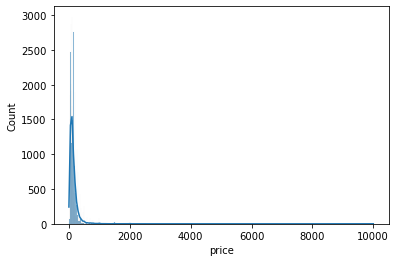

In [33]:
sns.histplot(data=df, x='price', kde=True)

<AxesSubplot:xlabel='price', ylabel='Count'>

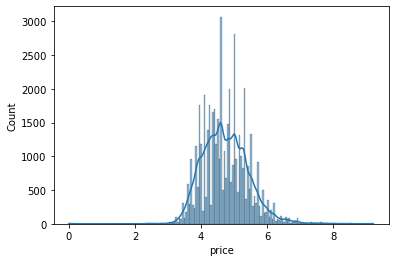

In [34]:
sns.histplot(np.log1p(df.price), kde=True)

It helped, but now we need to deal with outliers

In [35]:
df = df[np.log1p(df['price']) < 8]
df = df[np.log1p(df['price']) > 3]

In [36]:
df['price'] = np.log1p(df['price'])

<AxesSubplot:xlabel='price', ylabel='Count'>

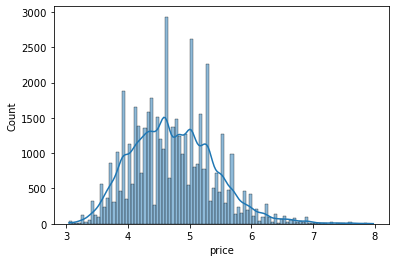

In [40]:
sns.histplot(data=df, x='price', kde=True)

#### 2.2 Minimum nights

Same distribution as **price**

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='minimum_nights', ylabel='Density'>

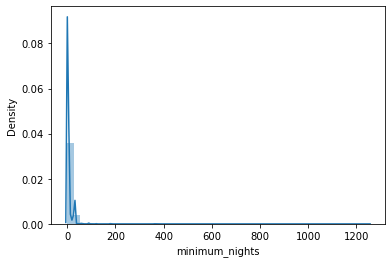

In [42]:
sns.distplot(df.minimum_nights)

In [43]:
df['minimum_nights'] = np.log1p(df['minimum_nights'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='minimum_nights', ylabel='Density'>

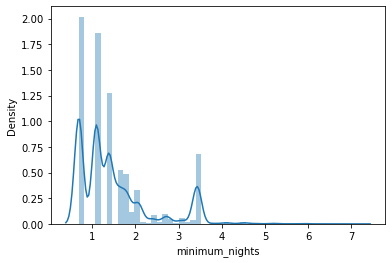

In [44]:
sns.distplot(df.minimum_nights)

#### 2.3 Reviews per month

Most variables are skewed to left, we need to deal with outliers

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='reviews_per_month', ylabel='Density'>

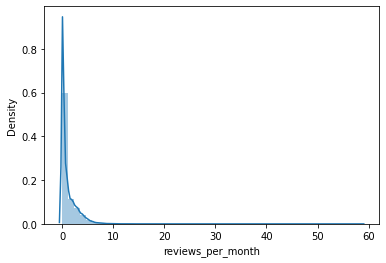

In [46]:
sns.distplot(df.reviews_per_month)

In [47]:
df['reviews_per_month'] = df[df['reviews_per_month'] < 17.5]['reviews_per_month']


In [53]:
df['no_reviews'] = df['reviews_per_month']==0

#### 2.4 Availability 365

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='availability_365', ylabel='Density'>

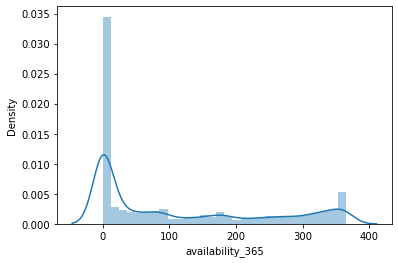

In [54]:
sns.distplot(df.availability_365)

As we can see, most variables are distributed near 0 and 365. We will code this feature :

- all_year_avail - if available more than 353 days a year
- low_avail -  if available less than 12 days a year

In [55]:
df['all_year_avail'] = df['availability_365']>353
df['low_avail'] = df['availability_365']< 12


In [56]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,no_reviews,all_year_avail,low_avail
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,0.693147,9,2762,0.21,6,365,False,True,False
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,0.693147,45,2976,0.38,2,355,False,True,False
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,1.386294,0,0,0.00,1,365,True,True,False
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,0.693147,270,3021,4.64,1,194,False,False,False
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,2.397895,9,2793,0.10,1,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,4.262680,1.098612,0,0,0.00,2,9,True,False,True
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,3.713572,1.609438,0,0,0.00,2,36,True,False,False
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,4.753590,2.397895,0,0,0.00,1,27,True,False,False
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,4.025352,0.693147,0,0,0.00,6,2,True,False,True


## 3 CatBoost

Creating subsets for catboost

In [57]:
X_ct, y_ct = df.drop(columns='price', axis=1), df.price


Getting columns where type is equal to object.
We will use them by passing to catboost model, catboost will encode them for us

In [58]:
categ_feat_idx = np.where(X_ct.dtypes == 'object')[0]
categ_feat_idx

array([0, 1, 4], dtype=int64)

Train test split for model validation

In [60]:
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(X_ct, y_ct, test_size=.3, shuffle=True, random_state=RANDOM_STATE) 

In [61]:
def ct_reg():
    return CatBoostRegressor(random_seed=RANDOM_STATE, silent=True,cat_features=categ_feat_idx)

In [62]:
ctb = ct_reg()

In [63]:
%%time
ctb.fit(X_train_ct, y_train_ct)

Wall time: 37.9 s


Cross validation

Model score with nMSE and kFold with 5 folds

In [64]:
n_folds =5
numerical_features =  X_ct.select_dtypes(exclude=['object'])
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train_ct, y_train_ct, scoring='neg_mean_squared_error', cv=kf)

In [65]:
cv_res = rmse_cv(ctb)

In [66]:
print('{}: {:.5f} +/- {:5f}'.format('Catboost without tunning', -cv_res.mean(), cv_res.std()))

Catboost without tunning: 0.17085 +/- 0.003561


### 3.1 Catboost tunning

In [93]:
param_distributions = {
    'iterations': [100, 150, 200, 250],  
    'learning_rate': [0.01,0.03,0.05, 0.1, 0.15, 0.2, 0.25, 0.28, 0.3],
    'max_depth': range(3,11),
    'l2_leaf_reg': scipy.stats.reciprocal(a=1e-2, b=1e1),# Samples *exponents* uniformly between a and b
    'od_type': ['Iter'],
    'od_wait': range(5,101,10)
    
}

In [94]:

def rand_cv(params, cat_ind):
    """
    creating Catboost RandomizedSearchCV with params and returns best regressor
    """
    clf = CatBoostRegressor(random_seed=17, silent=True, cat_features=cat_ind)
    return RandomizedSearchCV(clf, param_distributions=params, n_iter=10, n_jobs=-1,
                              scoring='neg_mean_squared_error', cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),verbose=1)

In [95]:
ctb_cv = rand_cv(param_distributions, categ_feat_idx)

In [96]:
%%time
ctb_cv.fit(X_train_ct, y_train_ct)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 2min 18s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001428B934C10>,
                   n_jobs=-1,
                   param_distributions={'iterations': [100, 150, 200, 250],
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001429423FF40>,
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2, 0.25, 0.28,
                                                          0.3],
                                        'max_depth': range(3, 11),
                                        'od_type': ['Iter'],
                                        'od_wait': range(5, 101, 10)},
                   scoring='neg_mean_squared_error', verbose=1)

In [97]:
print('{}: {:.5f}'.format('Catboost with tunning', -ctb_cv.best_score_))

Catboost with tunning: 0.17259


In [98]:
print(f"Best params : {ctb_cv.best_params_}")

Best params : {'iterations': 250, 'l2_leaf_reg': 0.36711560371691443, 'learning_rate': 0.25, 'max_depth': 6, 'od_type': 'Iter', 'od_wait': 5}


## ** Data frame for saving results and function  to generate them** 

In [88]:
res_tab = pd.DataFrame({"Model" : 'CatBoost untunned', 'Train error': cv_res.mean(), 'Test error': mean_squared_error(y_test_ct, ctb.predict(X_test_ct))},index=[0],)

In [89]:
res_tab

,Model,Train error,Test error
0,CatBoost untunned,-0.170855,0.170899


In [90]:
def append_res(clf, X_train, y_train, X_test, y_test, name):
    pred_ctb_train = clf.predict(X_train)
    error_train = mean_squared_error(y_train, pred_ctb_train)
    pred_ctb_test = clf.predict(X_test)
    error_test = mean_squared_error(y_test, pred_ctb_test)
    return res_tab.append({"Model" : name, 'Train error': error_train, 'Test error': error_test}, ignore_index=True)

In [99]:
res_tab = append_res(ctb_cv, X_train_ct, y_train_ct, X_test_ct, y_test_ct, 'CatBoost Tunned')

In [102]:
res_tab

,Model,Train error,Test error
0,CatBoost untunned,-0.170855,0.170899
2,CatBoost Tunned,0.147053,0.172898


**Note** I've tried a lot of params, but tunned model still overfitting

### 4.Light gbm

### 4.1 Preprocessing data

In [104]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,no_reviews,all_year_avail,low_avail
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,0.693147,9,2762,0.21,6,365,False,True,False
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,0.693147,45,2976,0.38,2,355,False,True,False
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,1.386294,0,0,0.00,1,365,True,True,False
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,0.693147,270,3021,4.64,1,194,False,False,False
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,2.397895,9,2793,0.10,1,0,False,False,True


In [135]:
X = df.drop('price', axis=1)
y=df.price

#### 4.2 Encoding categorical variables

In [136]:
categorical_col = [column for column in df.columns if df[column].dtype == 'object']

In [137]:
for feat in categorical_col:
    print(f'Feature {feat} has {df[feat].nunique()} unique variables')

Feature neighbourhood_group has 5 unique variables
Feature neighbourhood has 221 unique variables
Feature room_type has 3 unique variables


We will use LabelEncoder to encode **neighbourhood_group** and **room_type**

In [138]:
le = LabelEncoder()
X[categorical_col[0]] = le.fit_transform(X[categorical_col[0]])
X[categorical_col[2]] = le.fit_transform(X[categorical_col[2]])
X

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,no_reviews,all_year_avail,low_avail
0,1,Kensington,40.64749,-73.97237,1,0.693147,9,2762,0.21,6,365,False,True,False
1,2,Midtown,40.75362,-73.98377,0,0.693147,45,2976,0.38,2,355,False,True,False
2,2,Harlem,40.80902,-73.94190,1,1.386294,0,0,0.00,1,365,True,True,False
3,1,Clinton Hill,40.68514,-73.95976,0,0.693147,270,3021,4.64,1,194,False,False,False
4,2,East Harlem,40.79851,-73.94399,0,2.397895,9,2793,0.10,1,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,1,Bedford-Stuyvesant,40.67853,-73.94995,1,1.098612,0,0,0.00,2,9,True,False,True
48891,1,Bushwick,40.70184,-73.93317,1,1.609438,0,0,0.00,2,36,True,False,False
48892,2,Harlem,40.81475,-73.94867,0,2.397895,0,0,0.00,1,27,True,False,False
48893,2,Hell's Kitchen,40.75751,-73.99112,2,0.693147,0,0,0.00,6,2,True,False,True


In [139]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [140]:
X[['no_reviews', 'all_year_avail', 'low_avail']] = X[['no_reviews', 'all_year_avail', 'low_avail']].astype('int')
X

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,no_reviews,all_year_avail,low_avail
0,1,Kensington,40.64749,-73.97237,1,0.693147,9,2762,0.21,6,365,0,1,0
1,2,Midtown,40.75362,-73.98377,0,0.693147,45,2976,0.38,2,355,0,1,0
2,2,Harlem,40.80902,-73.94190,1,1.386294,0,0,0.00,1,365,1,1,0
3,1,Clinton Hill,40.68514,-73.95976,0,0.693147,270,3021,4.64,1,194,0,0,0
4,2,East Harlem,40.79851,-73.94399,0,2.397895,9,2793,0.10,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,1,Bedford-Stuyvesant,40.67853,-73.94995,1,1.098612,0,0,0.00,2,9,1,0,1
48891,1,Bushwick,40.70184,-73.93317,1,1.609438,0,0,0.00,2,36,1,0,0
48892,2,Harlem,40.81475,-73.94867,0,2.397895,0,0,0.00,1,27,1,0,0
48893,2,Hell's Kitchen,40.75751,-73.99112,2,0.693147,0,0,0.00,6,2,1,0,1


##### One-hot encoing for **neighbourhood** feature.
I'm not sure if it's the best encoding technique to use here. But anyway we will use it here

In [141]:
X = pd.get_dummies(X)

#### Train test split

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39027, 234)
Dimensions of the training target vector: (39027,)
Dimensions of the test feature matrix: (9757, 234)
Dimensions of the test target vector: (9757,)


### 4.3 Scaling features

In [144]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [145]:
# function for cross validation on any model
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

### 4.4 Base model

In [146]:
lgbm = LGBMRegressor(n_jobs=-1, random_state=RANDOM_STATE, silent=True)
cross_val = rmse_cv(lgbm)
print('{}: {:.5f} +/- {:5f}'.format('lgbm without tunning', -cross_val.mean(), cross_val.std()))

lgbm without tunning: 0.17390 +/- 0.005864


In [172]:
lgbm.fit(X_train, y_train)

LGBMRegressor(random_state=17)

In [174]:
res_tab = append_res(lgbm, X_train, y_train, X_test, y_test, 'LGBM untunned')

In [175]:
res_tab

,Model,Train error,Test error
0,CatBoost untunned,-0.170887,0.170927
1,CatBoost Tunned,0.146618,0.172563
2,LGBM untunned,0.157152,0.176926


### 4.5 Tunning LGBM

In [147]:
params = {
    "max_depth": range(2,20),
    'learning_rate': scipy.stats.uniform(0.01, 0.3),
    "num_leaves":range(10, 101,10),
    'n_estimators': range(10,101,10)
}

lgbm = LGBMRegressor(n_jobs=-1, random_state=RANDOM_STATE, silent=True)

lgbm_cv = RandomizedSearchCV(lgbm, param_distributions=params, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
lgbm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
                   estimator=LGBMRegressor(random_state=17), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000142A08509A0>,
                                        'max_depth': range(2, 20),
                                        'n_estimators': range(10, 101, 10),
                                        'num_leaves': range(10, 101, 10)},
                   scoring='neg_mean_squared_error', verbose=2)

In [148]:
lgbm_cv.best_params_

{'learning_rate': 0.11152483718054085,
 'max_depth': 7,
 'n_estimators': 80,
 'num_leaves': 70}

In [149]:
res_tab = append_res(lgbm_cv, X_train, y_train, X_test, y_test, 'LGBM tunned')

In [150]:
res_tab

,Model,Train error,Test error
0,CatBoost untunned,-0.170855,0.170899
1,CatBoost Tunned,0.147053,0.172898
2,LGBM tunned,0.151746,0.176485


### 5 XGBoost

Creating base XGBRegressor model

In [151]:
xgb_baseline = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
# kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
# cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)

[15:55:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [152]:
res_tab = append_res(xgb_baseline, X_train, y_train, X_test, y_test, 'XGB untunned')

In [153]:
res_tab

,Model,Train error,Test error
0,CatBoost untunned,-0.170855,0.170899
1,CatBoost Tunned,0.147053,0.172898
2,LGBM tunned,0.151746,0.176485
3,XGB untunned,0.124007,0.179031


### 5.1 Tunning XGB

**Let's see what's learning rate is the best**

In [ ]:
d = {'Learning Rate':[],
            'Test Error': [],
            'Training Error': []}
for lr in [0.01, 0.1, 0.05, 0.07, 0.15, 0.06,0.03]:
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5)
    xgb_model.fit(X_train, y_train, verbose=1)
    y_train_xgb = xgb_model.predict(X_train)
    y_test_xgb = xgb_model.predict(X_test)
    d['Learning Rate'].append(lr)
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))
    d['Test Error'].append(mean_squared_error(y_test_xgb, y_test))



xgb_tuning_1 = pd.DataFrame(d)
xgb_tuning_1


Best learning rate - 0.3

In [261]:
xgb_tuning_1.sort_values(by='Test Error')

,Learning Rate,Test Error,Training Error
6,0.03,0.178316,0.137322
0,0.01,0.178515,0.152714
2,0.05,0.179031,0.124007
5,0.06,0.180322,0.116285
3,0.07,0.181994,0.110332
1,0.10,0.183217,0.094341
4,0.15,0.186841,0.074288


#### max_depth and min_child_weight optimization

In [263]:
n_folds = 3
d = {'max_depth':[],
             'min_child_weight': [],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
xgbreg = XGBRegressor(n_estimators=2, learning_rate=0.03, early_stopping=5)
params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}
#print(params2)
#xgb_random.fit(X_train, y_train)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(X_train)
for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=md, min_child_weight=mcw )
        cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        # makes no sense to look at max/min when we only have 3 CV folds
        #d['Max CV Error'].append(max(cv_res)
        #d['Min CV Error'].append(max(cv_res)
        d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

xgb_tuning_2 = pd.DataFrame(d)
xgb_tuning_2      

[01:29:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:29:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping" } might not be used.

  This may not be accurate due to some parameters are onl

,max_depth,min_child_weight,Mean CV Error,CV Error Std,Training Error
0,3,1,0.176195,0.001617,0.153920
1,3,3,0.174992,0.001363,0.154811
2,3,5,0.175421,0.001188,0.154853
3,5,1,0.175547,0.002293,0.117493
4,5,3,0.174555,0.002233,0.118034
5,5,5,0.174770,0.002092,0.120049
6,7,1,0.178206,0.002304,0.071880
7,7,3,0.177416,0.001748,0.075137
8,7,5,0.177800,0.001893,0.079953
9,9,1,0.180941,0.003107,0.035643


(0.172, 0.181)

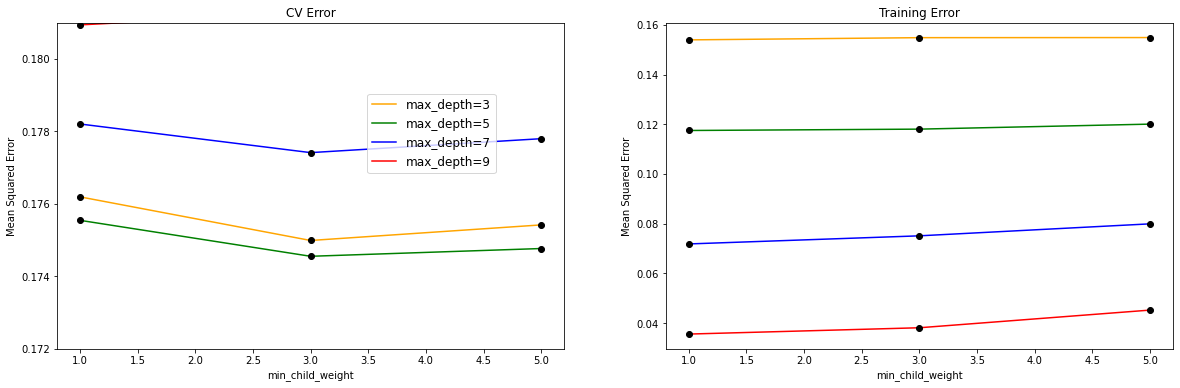

In [264]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

colors = ['orange','green','blue','red']

for i, md in enumerate(params2['max_depth']):
    color = colors[i]
    xgb_tuning_3 = xgb_tuning_2[xgb_tuning_2['max_depth']==md]
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], color=color, label= 'max_depth='+str(md))
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], 'o', color='black', label='_nolegend_')
    #ax.fill_between(xgb_tuning_3['Max_depth'], xgb_tuning_3['Mean CV Error'] - xgb_tuning_3['CV Error Std'], 
                    #xgb_tuning_3['Mean CV Error'] + xgb_tuning_3['CV Error Std'], color='r', alpha=.1, label='_nolegend_')
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], color=color, label='max_depth='+str(md))
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], 'o', color='black', label='_nolegend_')

for ax in axes:
    ax.set_xlabel('min_child_weight')
    ax.set_ylabel('Mean Squared Error')
    
axes[0].set_title('CV Error')
axes[1].set_title('Training Error')

axes[0].legend(fontsize=12, bbox_to_anchor=(0.6, .52, .7, .602), loc=3,);
axes[0].set_ylim([0.172, 0.181])

In [265]:
print('Optimal parameter values are: ')
best = xgb_tuning_2.iloc[xgb_tuning_2.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

Optimal parameter values are: 
max_depth: 5
min_child_weight: 3


### 6. Best model

In [267]:
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [289]:
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.03, early_stopping=5, max_depth=5, min_child_weight=3, gamma=0.01 )
# xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 

[02:13:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping=5,
             gamma=0.01, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [290]:
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)

In [291]:
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.190033,0.002915,0.15017,0.179835,0.673239,0.606698


In [155]:
res_tab

,Model,Train error,Test error
0,CatBoost untunned,-0.170855,0.170899
1,CatBoost Tunned,0.147053,0.172898
2,LGBM tunned,0.151746,0.176485
3,XGB untunned,0.124007,0.179031
